# Brain Tumor Classification via Convolutional and Capsule networks.

Inspired by BRAIN TUMOR TYPE CLASSIFICATION VIA CAPSULE NETWORKS: https://arxiv.org/pdf/1802.10200.pdf

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import itertools
import warnings

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
from skimage import img_as_float
from skimage.exposure import equalize_hist
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from skimage.measure import block_reduce
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
import pandas as pd
from os import listdir

from tqdm import tqdm_notebook

import h5py

/home/use/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Load Data:

In [3]:
def read_h5py_folder(path, indicies=(0,10)):
    """Read .mat data from specifed folder.
    
    Args:
        path: folder
        indicies: specifies a range of indicies if partial download is required
        
    Returns:
        Returns pandas dataframe where #rows = #observations
        and colums specify labels, Patient ID, image, tumor border, tumor mask (binary image)
    """
    columns = ['label', 'PID', 'image', 'tumorBorder', 'tumorMask']
    tmp_df = pd.DataFrame(data = np.zeros((indicies[1]-indicies[0], len(columns))), columns=columns, dtype=np.object)
    files = listdir(path)

    for i, each_file in enumerate(files[indicies[0]:indicies[1]]):
        if each_file[-3:]=='mat':
            data = h5py.File(path + '/' + each_file)['cjdata']
            tmp_df['label'][i] = data['label'][0][0]
            tmp_df['PID'][i] = data['PID'][0][0]
            tmp_df['image'][i] = img_as_float(data['image'][:])
            tmp_df['tumorBorder'][i] = data['tumorBorder'][0]
            tmp_df['tumorMask'][i] = img_as_float(data['tumorMask'][:])
        else:
            print('not .mat file dropped')
            tmp_df['label'][i], tmp_df['PID'][i], tmp_df['image'][i] = np.NaN, np.NaN, np.NaN
            tmp_df['tumorBorder'][i], tmp_df['tumorMask'][i] = np.NaN, np.NaN
    tmp_df.dropna(axis=0, inplace=True)
    tmp_df.reset_index(inplace=True)
    return tmp_df

In [4]:
#load data from several folders
data=read_h5py_folder(path='data/brainTumorDataPublic_1766', indicies=(0,766))
data1=read_h5py_folder(path='data/brainTumorDataPublic_7671532', indicies=(0,766))
data2=read_h5py_folder(path='data/brainTumorDataPublic_15332298', indicies=(0,766))
data3=read_h5py_folder(path='data/brainTumorDataPublic_22993064', indicies=(0,766))

In [5]:
#merge into one dataframe
data = pd.concat([data,data1,data2,data3],axis=0,ignore_index=True).reset_index(drop=True)
del data1,data2,data3

#Let's also check what's the distribution of the target
data.label.value_counts()

2.0    1426
3.0     930
1.0     708
Name: label, dtype: int64

In [6]:
data.head()

,index,label,PID,image,tumorBorder,tumorMask
0,0,2,49,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[284.54355400696863, 305.05923344947735, 298.8...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,49,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[323.5069316290968, 165.09547957104735, 314.81...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,1,57,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[260.5667868372567, 111.32424288382795, 258.62...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3,1,57,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[203.57637734408124, 238.69107998640095, 191.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,1,49,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[362.33467929947756, 190.76187165611123, 351.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


###### Check data:

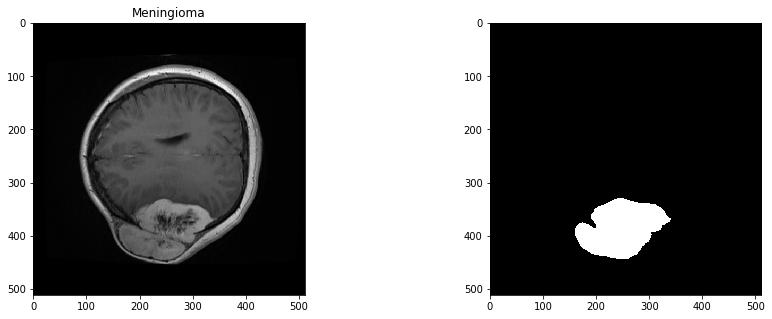

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(data['image'][4], cmap='gray')
ax[0].set_title('Meningioma')
ax[1].imshow(data['tumorMask'][4], cmap='gray');

In [8]:
def get_tumor_border(img, border):
    """Delinates particular tumor border
    
    Args:
        img: original image
        border: array of tumor border cordinates (x1,y1,x2,y2...)
        
    Returns:
        Returns a binary image with tumor border countour
    """
    border_img = np.zeros_like(img)
    border_ = np.array(border, dtype=np.int16)
    border_array = border_.reshape(border_.shape[0]//2,2)
    for each_idx_pair in border_array:
        border_img[each_idx_pair[0], each_idx_pair[1]] = 1.
    return img_as_float(border_img)

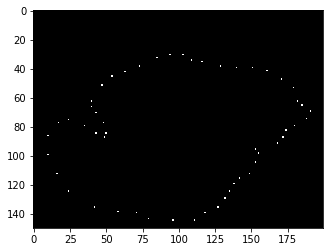

In [9]:
idx = 4
border = get_tumor_border(img = data['image'][idx], border=data['tumorBorder'][idx])
plt.imshow(border[300:450,150:350],cmap='gray');

# Preprocessing:

 - ###### Augmentation:

In [10]:
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def augment(image, mask, flip_p1=0.7, flip_p2=0.7, factor=2):
    """Produce an augmented image using elastic transformations and rotations
    
    Args:
        image: original image to augment
        mask: mask of an image to augment
        flip_p1: probability of flip along axis 0
        flip_p1: probability of flip along axis 1
        factor: strength of an elastic transformation
        
    Returns:
        Returns a tuple of (augmented image, augmented tumor mask)
    """
    
    img_mask = np.copy(np.stack([image, mask], axis=2))
    
    def elastic_transform(image, alpha, sigma, alpha_affine):
    
        random_state = np.random.RandomState(None)
        shape = image.shape
        shape_size = shape[:2]

        center_square = np.float32(shape_size) // 2
        square_size = min(shape_size) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dz = np.zeros_like(dx)

        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

        return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    
    transformed = elastic_transform(img_mask, img_mask.shape[1] * factor, 0.08*img_mask.shape[1], 0.08*img_mask.shape[1])
    
    if np.random.rand() < flip_p1:
        transformed = np.flip(transformed, axis=0).copy()
    
    if np.random.rand() < flip_p2:
        transformed = np.flip(transformed, axis=1).copy()
    
    out_img = transformed[...,0].copy()
    out_mask = transformed[...,1].copy()
        
    return img_as_float(out_img), img_as_float(out_mask)

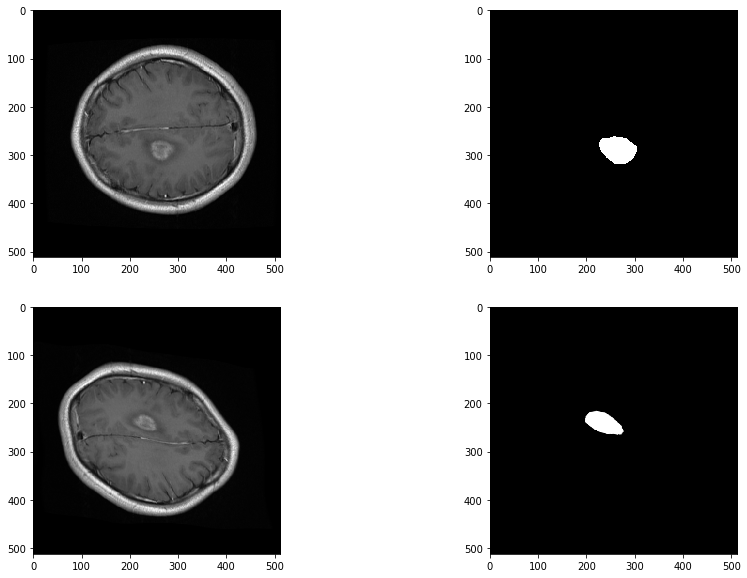

In [11]:
img = data['image'][0]
mask = data['tumorMask'][0]
augi, augm = augment(img, mask, factor=4)

fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].imshow(img, cmap='gray')
ax[0,1].imshow(mask, cmap='gray')
ax[1,0].imshow(augi, cmap='gray')
ax[1,1].imshow(augm, cmap='gray');

 - ###### Histogram equalization:

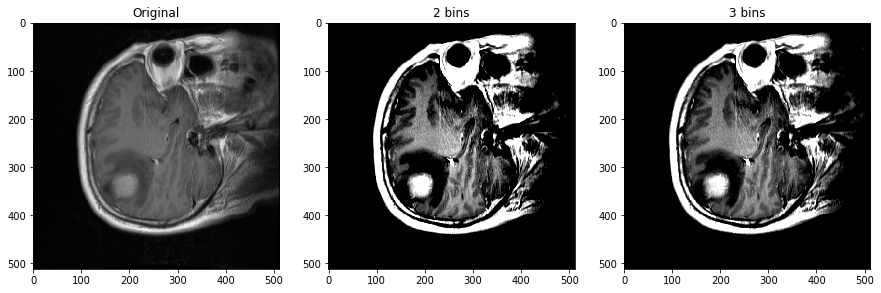

In [12]:
# Since we have only grayscale images a good idea would be to try histogram equalization as preprocessing.
idx = 1
img = data['image'][idx]
mask = data['tumorMask'][idx]
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(equalize_hist(img, nbins=2,mask=mask), cmap='gray')
ax[2].imshow(equalize_hist(img, nbins=3, mask=mask), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('2 bins')
ax[2].set_title('3 bins');

 - ###### Prepare data and split into test / train:

In [13]:
#For the purposes of computational efficiency we will need to downscale images in the dataset

def resize_fast(X, size=256):
    """Resize an image in dataset. It's a more qualified resize than pythorch's default.
    
    Args:
        X: dataset, containing images to resize
        size: a final size, assumes to be a power of 2.
        
    Returns:
        Returns a same dataframe, but with images resized.
    """
    
    X['shape_'] = X['image'].apply(lambda x: x.shape[0])
    mean_size = X['shape_'].mean()
    bad_obs_idx = X[X.shape_ <= mean_size].index.tolist()
    bad_obs = X.iloc[bad_obs_idx,:].drop('shape_', axis=1).reset_index(drop=True).copy()
    good_obs = X.drop(bad_obs_idx, axis=0).drop('shape_', axis=1).reset_index(drop=True).copy()

    while not good_obs.image[0].shape[0] <= size:
        good_obs.image= good_obs.image.apply(lambda x: block_reduce(x, (2,2), func=np.max))
        good_obs.tumorMask= good_obs.tumorMask.apply(lambda x: block_reduce(x, (2,2), func=np.max))
    
    while not bad_obs.image[0].shape[0] <= size:
        bad_obs.image= bad_obs.image.apply(lambda x: block_reduce(x, (2,2), func=np.max))
        bad_obs.tumorMask= bad_obs.tumorMask.apply(lambda x: block_reduce(x, (2,2), func=np.max))
        
    out = pd.concat([good_obs,bad_obs],axis=0,ignore_index=True)
    out.reset_index(inplace=True, drop=True)
    return out

In [14]:
def get_train_test_data(X ,ratio):
    """Produce train/test split of a given dataset.
    
    Args:
        X: an original dataset to split
        ratio: a ratio of a test size
        
    Returns:
        Returns a tuple of (training dataframe, test dataframe)
    """
    
    df = shuffle(X.copy()).reset_index(drop=True)
    train_idx = int(np.round(df.shape[0]*ratio))
    train_df = df[train_idx:]
    test_df = df[:train_idx]
    train_df.reset_index(inplace=True, drop = True)
    test_df.reset_index(inplace=True, drop = True)
    try:
        return train_df.drop('index', axis=1), test_df.drop('index', axis=1)
    except:
        return train_df, test_df

In [15]:
data = resize_fast(data, 128) 

In [16]:
X_train, X_test = get_train_test_data(data, 0.2)

 - ###### Wrap the data into PyTorch class and feed DataLoader:

In [17]:
# we need to wrap the data into PyTorch class to feed the DataLoader
class tumor_data(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        
        if dataframe.image[0].ndim==2:
            images = dataframe.image.apply(lambda x: x.reshape(1, x.shape[0], x.shape[1]))
            
        self.images = images
        self.labels = dataframe.label.tolist()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        img = torch.from_numpy(self.images[idx])
        target = torch.from_numpy(np.array([self.labels[idx]-1]))
        
        return img, target

In [18]:
train_data = tumor_data(X_train)
test_data = tumor_data(X_test)

In [19]:
batch_size, n_iters = 25, 700
n_epoches = int(n_iters / (len(train_data)/batch_size))
n_epoches

7

In [20]:
train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

# Vanilla CNN:

$references$: Deep learning for brain tumor classification. JS Paul, AJ Plassard, BA Landman, D Fabbri. SPIE Medical Imaging.

In [21]:
class vanilaCNN(nn.Module):
    def __init__(self):
        super(vanilaCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)
        #256 - 32*61*61
        #128 - 64, 29, 29
        self.lin1 = nn.Linear(64*29*29, 800) #128
        self.fc1 = nn.ReLU()
        self.lin2 = nn.Linear(800, 800)
        self.fc2 = nn.ReLU()
        self.lin3 = nn.Linear(800, 3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.lin1(out.view(out.size(0),-1))
        out = self.fc1(out)
        out = self.lin2(out)
        out = self.fc2(out)
        out = self.lin3(out)
        out = self.sigmoid(out)
        return out

In [22]:
vanilla_model=vanilaCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vanilla_model.parameters(), lr=1e-5)

 - ##### Train:

In [23]:
history = list()

for epoch in tqdm_notebook(range(n_epoches)):
    for i,(image, label) in enumerate(train_feeder):
        inputs = Variable(image.cuda()).float()
        labels = Variable(label.cuda())
        
        optimizer.zero_grad()
        outputs = vanilla_model(inputs)
        
        loss = criterion(outputs, labels.long().view(-1))
        
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())

A Jupyter Widget

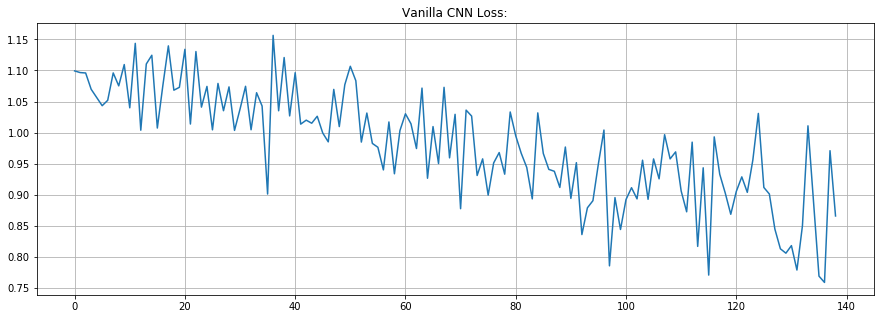

In [24]:
plt.figure(figsize=(15,5))
plt.title('Vanilla CNN Loss:')
plt.plot(history[::5])
plt.grid();

 - ##### Test:

In [25]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in tqdm_notebook(test_feeder):
    
    inputs = Variable(image.cuda()).float()
    outputs = vanilla_model(inputs)
    
    pred = np.argmax(outputs.data.cpu().numpy())
    true = labels.numpy()[0][0]
    correct += int(pred == true)
    y_pred.append(pred)
    y_true.append(true)

A Jupyter Widget

 - ##### Accuracy:

In [26]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
print('Accuracy:', correct/len(test_data))
print('F1 Score:', f1_score(y_true, y_pred, average='macro', labels=np.unique(y_true)))

Accuracy: 0.6818923327895595
F1 Score: 0.5107737676351328


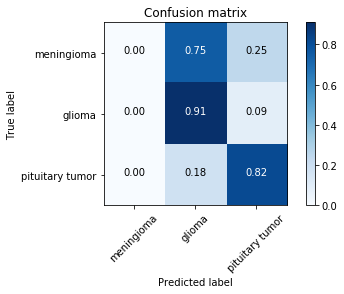

In [28]:
plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])

# Vanilla CNN with histogram equalization:

 - ##### Prepare data:

In [29]:
def hist_equalize(X, bins=2):
    """Produce histogram equalization of a given image
    
    Args:
        X: an original image
        nbins: a number of histogram bins to equalize
        
    Returns:
        Returns a histogram equalize image
    """
    for i in range(X.shape[0]):
        X.image[i] = equalize_hist(X.image[i], nbins=bins, mask=X.tumorMask[i])
    return X

In [30]:
data_heq=hist_equalize(data)

In [31]:
X_train, X_test = get_train_test_data(data_heq, 0.2)

train_data = tumor_data(X_train)
test_data = tumor_data(X_test)

In [32]:
train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

 - ##### Train:

In [33]:
vanilla_model=vanilaCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vanilla_model.parameters(), lr=1e-5)

In [34]:
history = list()

for epoch in tqdm_notebook(range(n_epoches)):
    for i,(image, label) in enumerate(train_feeder):
        inputs = Variable(image.cuda()).float()
        labels = Variable(label.cuda())
        
        optimizer.zero_grad()
        outputs = vanilla_model(inputs)
        
        loss = criterion(outputs, labels.long().view(-1))
        
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())

A Jupyter Widget

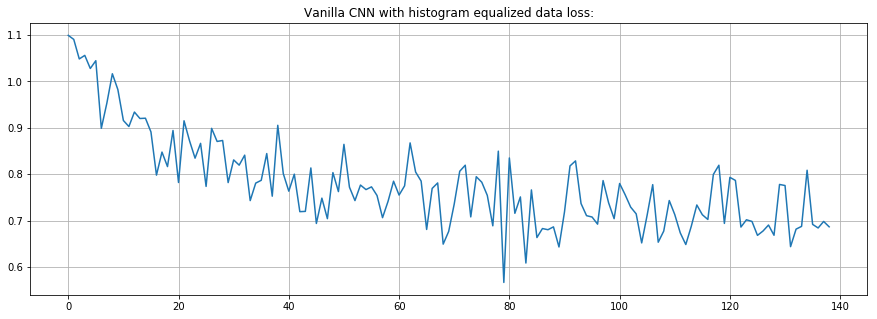

In [35]:
plt.figure(figsize=(15,5))
plt.title('Vanilla CNN with histogram equalized data loss:')
plt.plot(history[::5])
plt.grid();

 - ##### Test:

In [36]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in tqdm_notebook(test_feeder):
    
    inputs = Variable(image.cuda()).float()
    outputs = vanilla_model(inputs)
    
    pred = np.argmax(outputs.data.cpu().numpy())
    true = labels.numpy()[0][0]
    correct += int(pred == true)
    y_pred.append(pred)
    y_true.append(true)

A Jupyter Widget

 - ##### Accuracy:

In [37]:
print('Accuracy:', correct/len(test_data))
print('F1 Score:', f1_score(y_true, y_pred, average='macro', labels=np.unique(y_true)))

Accuracy: 0.8531810766721044
F1 Score: 0.8335640977227093


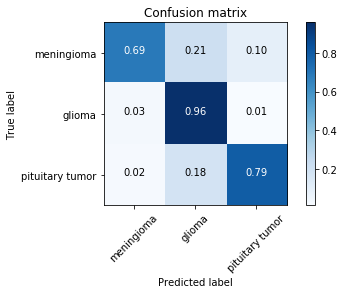

In [38]:
plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])

In [39]:
del vanilla_model #just clean the memory

# Densenet:

$references$: https://arxiv.org/pdf/1608.06993.pdf

![title](denseblock.png)

![title](densenet.png)

 - ###### Define a model:

In [40]:
class basic_block(nn.Module):
    def __init__(self, in_channles, out_channels):
        super(basic_block, self).__init__()
        
        self.batch = nn.BatchNorm2d(in_channles)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channles, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.batch(x)
        x = self.relu(x)
        x = self.conv(x)
        return x
    
class bottleneck_block(nn.Module):
    def __init__(self, in_channles, out_channels):
        super(bottleneck_block, self).__init__()
        
        self.batch = nn.BatchNorm2d(in_channles)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channles, out_channels, kernel_size=1, padding=0)
        
    def forward(self, x):
        x = self.batch(x)
        x = self.relu(x)
        x = self.conv(x)
        return x
    
class dense_block(nn.Module):
    def __init__(self, in_channles, out_channels):
        super(dense_block, self).__init__()
        
        self.block1 = basic_block(in_channles, out_channels)
        self.block2 = basic_block(out_channels, out_channels)
        self.block3 = basic_block(2*out_channels, 2*out_channels)
        self.block4 = bottleneck_block(4*out_channels, out_channels)
        
    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        cat1 = torch.cat((x1, x2), 1)
        x3 = self.block3(cat1)
        cat2 = torch.cat((x1,x2,x3),1)
        x4 = self.block4(cat2)
        return x4
        
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        self.dense1 = dense_block(1, 64)
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.dense2 = dense_block(64, 64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.dense3 = dense_block(64,64)
        
        self.lin1= nn.Linear(64*29*29,900)
        self.fc1 = nn.ReLU()
        self.fc2 = nn.ReLU()
        self.lin2 = nn.Linear(900,3)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
                             
        x = self.dense1(x)
        x = self.conv1(x)
        x = self.maxpool1(x)
        
        x = self.dense2(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.dense3(x)
                             
        x = self.lin1(x.view(x.size(0),-1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.lin2(x)
                             
        return self.sig(x)
        

 - ##### Train:

In [41]:
train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=10, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [42]:
DenseNet_model=DenseNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DenseNet_model.parameters(), lr=1e-4)

In [43]:
history = list()

for epoch in tqdm_notebook(range(10)):
    for image, label in train_feeder:
        inputs = Variable(image.cuda()).float()
        labels = Variable(label.cuda())
        
        optimizer.zero_grad()
        outputs = DenseNet_model(inputs)
        
        loss = criterion(outputs, labels.long().view(-1))
        
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())
        
    if epoch == 3:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10

A Jupyter Widget

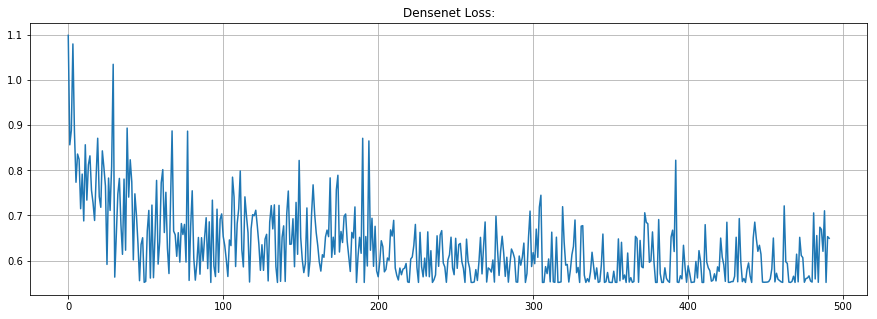

In [44]:
plt.figure(figsize=(15,5))
plt.title('Densenet Loss:')
plt.plot(history[::5])
plt.grid();

 - ##### Test:

In [45]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in tqdm_notebook(test_feeder):
    
    inputs = Variable(image.cuda()).float()
    outputs = DenseNet_model(inputs)
    
    pred = np.argmax(outputs.data.cpu().numpy())
    true = labels.numpy()[0][0]
    correct += int(pred == true)
    y_pred.append(pred)
    y_true.append(true)
    
print('Accuracy:', correct/len(test_data))

A Jupyter Widget


Accuracy: 0.8466557911908646


 - ##### Accuracy:

In [46]:
print('Accuracy:', correct/len(test_data))
print('F1 Score:', f1_score(y_true, y_pred, average='macro', labels=np.unique(y_true)))

Accuracy: 0.8466557911908646
F1 Score: 0.8088146637036576


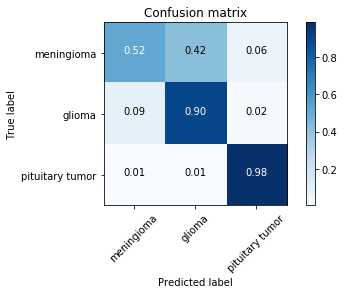

In [47]:
plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])

- ##### Densenet + augmentation:

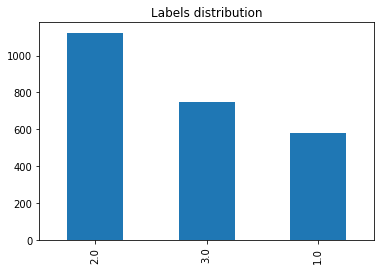

In [48]:
X_train.label.value_counts().plot(kind='bar')
plt.title('Labels distribution');

In [71]:
def augment_dataset(X, aug_class, n):
    """Perform an augmentation of a particular class of images in dataframe
    
    Args:
        X: an original dataframe with images and tumorMasks
        aug_class: a particular class to augment
        n: number of augmented samples
        
    Returns:
        Returns an dataframe with augmented samples.
    """
    
    X_aug = shuffle(X[X.label==aug_class].copy()).reset_index(drop=True)
    augmented = X_aug.iloc[:n,:].copy().reset_index(drop=True)

    for i in tqdm_notebook(range(n)):
        augmented_img, augmented_mask = augment(X_aug.image[i], X_aug.tumorMask[i], factor=2)
        augmented.image[i], augmented.tumorMask[i] = augmented_img, augmented_mask
    
    conc_df = pd.concat([X.copy(),augmented],axis=0,ignore_index=True).reset_index(drop=True)
    return conc_df

In [72]:
X_train_augmented = augment_dataset(X_train, aug_class=1, n=300)
X_train_augmented = augment_dataset(X_train_augmented, aug_class=2, n=100)
print('Original X_train shape:',X_train.shape)
print('X train with augmented data shape:', X_train_augmented.shape)

A Jupyter Widget

A Jupyter Widget


Original X_train shape: (2451, 5)
X train with augmented data shape: (2851, 5)


In [73]:
tumor_data_aug = tumor_data(X_train_augmented)
train_feeder = torch.utils.data.DataLoader(dataset=tumor_data_aug, batch_size=8, shuffle=True)

In [74]:
DenseNet_model=DenseNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DenseNet_model.parameters(), lr=1e-4)

 - ##### Train on augmented data:

In [75]:
history = list()

for epoch in tqdm_notebook(range(10)):
    for image, label in train_feeder:
        inputs = Variable(image.cuda()).float()
        labels = Variable(label.cuda())
        
        optimizer.zero_grad()
        outputs = DenseNet_model(inputs)
        
        loss = criterion(outputs, labels.long().view(-1))
        
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())
        
    if epoch == 3:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10

A Jupyter Widget

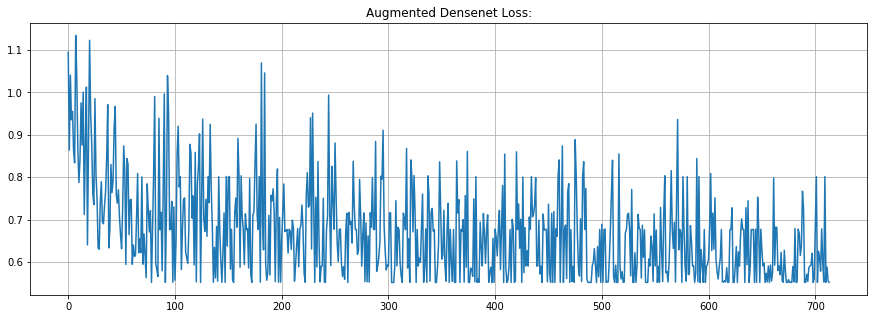

In [76]:
plt.figure(figsize=(15,5))
plt.title('Augmented Densenet Loss:')
plt.plot(history[::5])
plt.grid();

 - ##### Test on augmented data:

In [77]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in tqdm_notebook(test_feeder):
    
    inputs = Variable(image.cuda()).float()
    outputs = DenseNet_model(inputs)
    
    pred = np.argmax(outputs.data.cpu().numpy())
    true = labels.numpy()[0][0]
    correct += int(pred == true)
    y_pred.append(pred)
    y_true.append(true)
    
print('Accuracy:', correct/len(test_data))

A Jupyter Widget


Accuracy: 0.8172920065252854


 - ##### Accuracy on augmented data:

In [78]:
print('Accuracy:', correct/len(test_data))
print('F1 Score:', f1_score(y_true, y_pred, average='macro', labels=np.unique(y_true)))

Accuracy: 0.8172920065252854
F1 Score: 0.8010535461002263


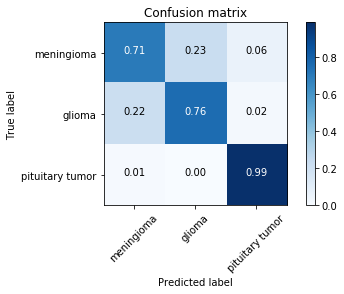

In [79]:
plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])

# CapsNet:

In [1]:
batch_size = 5
n_epoches=20

train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

NameError: name 'torch' is not defined

In [ ]:
from capsnet import CapsuleLoss, CapsuleNet

caps_model = CapsuleNet(img_shape=(128, 128), n_pcaps=8, n_ccaps=3, conv_channels=64, n_iterations=3).cuda()
criterion = CapsuleLoss()
optimizer = torch.optim.Adam(caps_model.parameters(), lr=1e-2)

In [ ]:
history = list()


for epoch in tqdm_notebook(range(n_epoches)):
    print(epoch)
    for i,(image, label) in enumerate(train_feeder):
        
        
        inputs = (image.float())
        label = label.long().squeeze()
        labels = torch.sparse.torch.eye(3).index_select(dim=0, index=label)

        inputs = Variable(inputs).cuda()
        labels = Variable(labels).cuda()
        
        optimizer.zero_grad()
        classes, reconstructions = caps_model(inputs)
        
        loss = criterion(inputs, labels, classes, reconstructions)
        
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Capsnet Loss:')
plt.plot(history[::5])
plt.grid()

In [ ]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in tqdm_notebook(test_feeder):
    
    inputs = Variable(image.cuda()).float()
    classes, reconstructions = caps_model(inputs)
    
    pred = np.argmax(classes.data.cpu().numpy())
    true = labels.numpy()[0][0]
    correct += int(pred == true)
    y_pred.append(pred)
    y_true.append(true)
    

In [ ]:
print('Accuracy:', correct/len(test_data))
print('F1 Score:', f1_score(y_true, y_pred, average='macro', labels=np.unique(y_true)))

In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])

# Comparison:

# Conclusion: